#Pomological Watercolor Generator
This is model 5 from my initial experimentations using a DCGAN to generate versions of the 'low res' images from the pomological watercolor collection (link)[]. We can find the data at (link)[], but here we import it pre-normalised and cleaned up into squares.

The model is also being loaded from a drive storage currently, will move to github when it's more stable.

Currently the model is asymmetric in the generator and the discriminator.

In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import torchvision
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchsummary import summary
from torchvision import transforms
import pickle
import glob
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams['figure.dpi'] = 150

from PIL import Image



Mount drive, as that's where the files are currently stored for me.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##configure the gpu

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Fri Mar 25 13:28:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setting up the model

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Number of channels in the training images. 
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps (Kernel, Filter) in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

#Dropout rate
dropout_rate = 0.2

#Dropout rate
dropout_rate_D = 0.35 #Tried 0.3 for one set of 10 with the new generator - seems too high so going back to 0.4

In [ ]:
#V3 - the idea of bigger features at the end and linear layers to compensate for size.
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
      super(Generator, self).__init__()

      self.network = nn.Sequential(
          nn.ConvTranspose2d(in_channels = nz, out_channels = ngf*4, kernel_size= 3, stride = 2, padding = 0, bias=False), 
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),
          nn.Dropout(p=dropout_rate), #was originally relu, not leakyrelu
  
          nn.ConvTranspose2d(ngf*4, ngf*4, 5, 3, 1, bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),
          nn.Dropout(p=dropout_rate),

          nn.ConvTranspose2d(ngf*4, ngf*2, 9, 3, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),
          nn.Dropout(p=dropout_rate),
  
          nn.ConvTranspose2d(ngf*2, ngf, 13, 1, 2, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
          nn.Dropout(p=dropout_rate),

          nn.ConvTranspose2d(ngf, out_channels = ngf, kernel_size= 17, stride = 3, padding = 2, bias=False), 
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
          nn.Dropout(p=dropout_rate), #was originally relu, not leakyrelu

          nn.ConvTranspose2d(ngf, nc, 4, 2, 0, bias=False),
          nn.Tanh()
      )
  
    def forward(self, input):
      output = self.network(input)
      return output #.view(-1,1).squeeze()

In [ ]:
# Discriminator for models 1-4. dropout rate 0.4 - trying 0.1 to improve accuracy now it has some training.

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
                
                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(p=dropout_rate_D),

                nn.Conv2d(ndf, ndf * 2, 7, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(p=dropout_rate_D),
                
                nn.Conv2d(ndf * 2, ndf * 3, 7, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 3),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(p=dropout_rate_D),

                nn.Conv2d(ndf * 3, ndf * 4, 7, 3, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(p=dropout_rate_D),

                nn.Conv2d(ndf * 4, 1, 7, 3, 0, bias=False),
                nn.Sigmoid()

            )
        
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

In [ ]:
dataloader =torch.load('/content/drive/MyDrive/datascience/poms/dataloader_128_normalised.ptt')
#dataloader =torch.load('/content/drive/MyDrive/datascience/poms/dataloader_64.ptt')
batch_size = 128

## Run below to train from a fresh state

In [ ]:
generator_model = Generator(nc = 3, nz = 100, ngf = 64) 
generator_model.apply(weights_init)
#generator_model.state_dict(torch.load('/content/drive/MyDrive/datascience/pom_generator.pt'))

generator_model.to(device)

discriminator_model = Discriminator(nc = 3, ndf = 64)
discriminator_model.apply(weights_init)
#discriminator_model.state_dict(torch.load('/content/drive/MyDrive/datascience/pom_discriminator.pt'))

discriminator_model.to(device)


# Initialize BCELoss function
criterion = nn.BCELoss()

real_label = torch.full((batch_size,), 1. , dtype=torch.float, device=device)
fake_label = torch.full((batch_size,), 0. , dtype=torch.float, device=device)



# Learning rate for optimizers (value suggested in original DCGAN paper)
lr_g = 0.0002
lr_d = 0.0002

# Beta1 hyperparam for Adam optimizers (value suggested in original DCGAN paper)
beta1 = 0.1

# Batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


In [ ]:
# Setup Adam optimizers for both G and D
D_optimizer = optim.Adam(discriminator_model.parameters(), lr=lr_d, betas=(beta1, 0.9))
G_optimizer = optim.Adam(generator_model.parameters(), lr=lr_g, betas=(beta1, 0.9))

In [ ]:
#Only run this if you're really starting fresh.
# Training Loop
num_epochs = 10
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_costs=[]
Wdist = []
epoch_count = 0
n_critic = 5

## run below if you want to continue training from a saved state

In [ ]:
# Learning rate for optimizers (value suggested in original DCGAN paper)
lr = 0.0002

# Beta1 hyperparam for Adam optimizers (value suggested in original DCGAN paper)
beta1 = 0.5

#Loss
criterion = nn.BCELoss()
#also the cell above.

#Model instances
generator_model = Generator(nc = 3, nz = 100, ngf = 64) 
discriminator_model = Discriminator(nc = 3, ndf = 64)

#Loading the states
checkpoint = torch.load('/content/drive/MyDrive/datascience/poms/pom-train-4_3_1.pt')
generator_model.load_state_dict(checkpoint['generator_state_dict'])
discriminator_model.load_state_dict(checkpoint['discriminator_state_dict'])
#epoch = checkpoint['epoch']
G_losses = checkpoint['G_loss']
D_losses = checkpoint['D_loss']
epoch_count=checkpoint['epoch_count']

#Number of epochs for this training run, done 10's so far. we count them.
num_epochs = 10

#Reload the test noise
fixed_noise = checkpoint['fixed_noise'].to(device)

#Move the models to the device
generator_model.to(device)
discriminator_model.to(device)

D_optimizer = optim.Adam(discriminator_model.parameters(), lr=lr, betas=(beta1, 0.999))
G_optimizer = optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, 0.999))
G_optimizer.load_state_dict(checkpoint['optimizerG_state_dict'])
D_optimizer.load_state_dict(checkpoint['optimizerD_state_dict'])

generator_model.train()
discriminator_model.train()

Discriminator(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): Conv2d(128, 192, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): Conv2d(192, 256, kernel_size=(7, 7), stride=(3, 3), padding=(1, 1), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (

## This is the training routine - I have been doing 10 epoch runs

In [ ]:
#parameters
iters = 0
img_list = []
epoch_count += num_epochs

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0): #train_loader


        real_images = data.to(device).float() #was data[0].todevice()
        b_size = real_images.size(0)
                
        real_label = torch.full((b_size,), 1. , dtype=torch.float, device=device)
        fake_label = torch.full((b_size,), 0. , dtype=torch.float, device=device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #
        

        ## Train with all-real batch
        discriminator_model.zero_grad()

        # Forward pass real batch through D
        real_output = discriminator_model(real_images).view(-1)
        D_x = real_output.mean().item()

        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake_images = generator_model(noise)
        #label.fill_(0.0)
        # Classify all fake batch with D
        fake_output = discriminator_model(fake_images.detach()).view(-1)
        D_G_z1 = fake_output.mean().item()


        #errD = discriminator_loss(real_output, fake_output)
        #errD.backward()
        #D_optimizer.step()

        # Calculate loss on all-real batch
        D_loss_real = criterion(real_output, real_label) # log(D(x)) 
        D_loss_real.backward()
        # Calculate loss on all-fake batch
        D_loss_fake = criterion(fake_output, fake_label) # log(1 - D(G(z)))
        D_loss_fake.backward()
        # Compute error of D as sum over the fake and the real batches
        D_loss = D_loss_real + D_loss_fake
        # Calculate gradients for D in backward pass
        
        D_optimizer.step()
        
              

        # ================================================================== #
        #                      Train the generator                           #
        # ================================================================== #
        generator_model.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        fake_output = discriminator_model(fake_images).view(-1)
        D_G_z2 = fake_output.mean().item()

        # Calculate G's loss based on this output
        # fake labels are real for generator cost
        G_loss = criterion(fake_output, real_label)
        # Calculate gradients for G (we are here just updating G weights and not D ones)
        G_loss.backward()
        # Update G
        G_optimizer.step()

        # Output training stats - train_loader = dataloader
        #if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch+1, num_epochs, i+1, len(dataloader), 
                  D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
       

        # Check how the generator is doing by saving G's output on fixed_noise
        if (epoch+1 % 10 == 0): #or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_images = generator_model(fixed_noise).detach().cpu()
            img_list.append(fake_images)

        iters += 1

Starting Training Loop...
[1/10][1/60]	Loss_D: 3.6694	Loss_G: 0.5515	D(x): 0.1232	D(G(z)): 0.0000 / 0.6715
[1/10][2/60]	Loss_D: 1.2644	Loss_G: 8.2048	D(x): 0.9986	D(G(z)): 0.6255 / 0.0041
[1/10][3/60]	Loss_D: 0.2494	Loss_G: 6.9915	D(x): 0.8330	D(G(z)): 0.0138 / 0.0074
[1/10][4/60]	Loss_D: 0.2839	Loss_G: 4.2880	D(x): 0.8185	D(G(z)): 0.0092 / 0.0399
[1/10][5/60]	Loss_D: 0.1317	Loss_G: 3.7728	D(x): 0.9833	D(G(z)): 0.0862 / 0.0499
[1/10][6/60]	Loss_D: 0.1560	Loss_G: 4.3155	D(x): 0.9757	D(G(z)): 0.1068 / 0.0345
[1/10][7/60]	Loss_D: 0.0759	Loss_G: 5.2753	D(x): 0.9724	D(G(z)): 0.0432 / 0.0120
[1/10][8/60]	Loss_D: 0.1312	Loss_G: 4.6315	D(x): 0.9312	D(G(z)): 0.0373 / 0.0197
[1/10][9/60]	Loss_D: 0.1702	Loss_G: 3.6851	D(x): 0.9085	D(G(z)): 0.0443 / 0.0552
[1/10][10/60]	Loss_D: 0.1800	Loss_G: 4.3192	D(x): 0.9487	D(G(z)): 0.0968 / 0.0376
[1/10][11/60]	Loss_D: 0.2409	Loss_G: 4.8182	D(x): 0.9121	D(G(z)): 0.1001 / 0.0215
[1/10][12/60]	Loss_D: 0.1722	Loss_G: 4.7643	D(x): 0.9369	D(G(z)): 0.0611 / 0.0252

## This is the sanity checks for sizes for a) file naming and b) to keep track of where things are after a run

In [ ]:
print('the current epoch count is {0}'.format(epoch_count))

NameError: ignored

In [ ]:
len(G_losses)

4200

#Looking at some fakes.

In [ ]:
generator_model.eval()
fake_poms = generator_model(fixed_noise).detach().cpu()

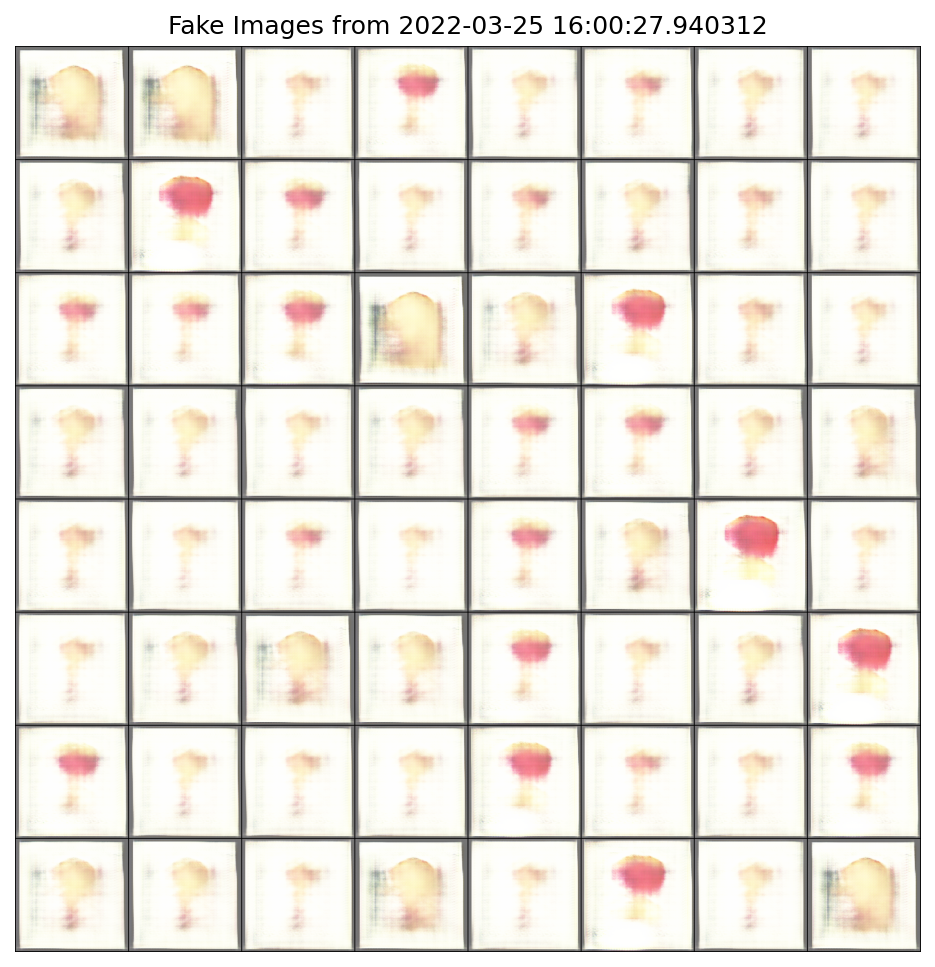

In [ ]:
#This is the batch of fakes to look at.
time = datetime.now()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images from {0}".format(time))
plt.imshow(np.transpose(vutils.make_grid(fake_poms[:64], padding=2, normalize=True),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


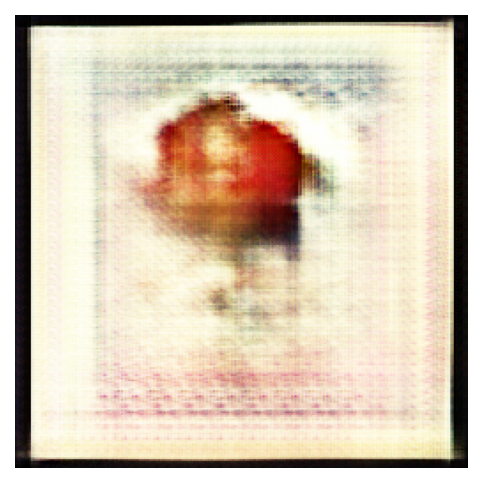

In [ ]:
#Plot the same single image - the noice apple
plt.axis("off")
#plt.title("Fake Images from {0}".format(now))
plt.imshow(fake_poms[69].squeeze(0).permute(1,2,0))

In [ ]:
#reset every new set of trials
generated_images = []

In [ ]:
#Run these if you are loading a set of trial runs to update the images over time
#model_4_3_2_samples = torch.load('/content/drive/MyDrive/datascience/poms/model_4_3_2_samples.ptt')
#generated_images = list(torch.unbind(model_4_3_2_samples))

In [ ]:
generated_images.append(fake_poms)
len(generated_images)

1

In [ ]:
model_4_3_2_samples = torch.stack(generated_images)
torch.save(model_4_3_2_samples, '/content/drive/MyDrive/datascience/poms/model_4_3_2_samples.ptt')

## Plotting loss

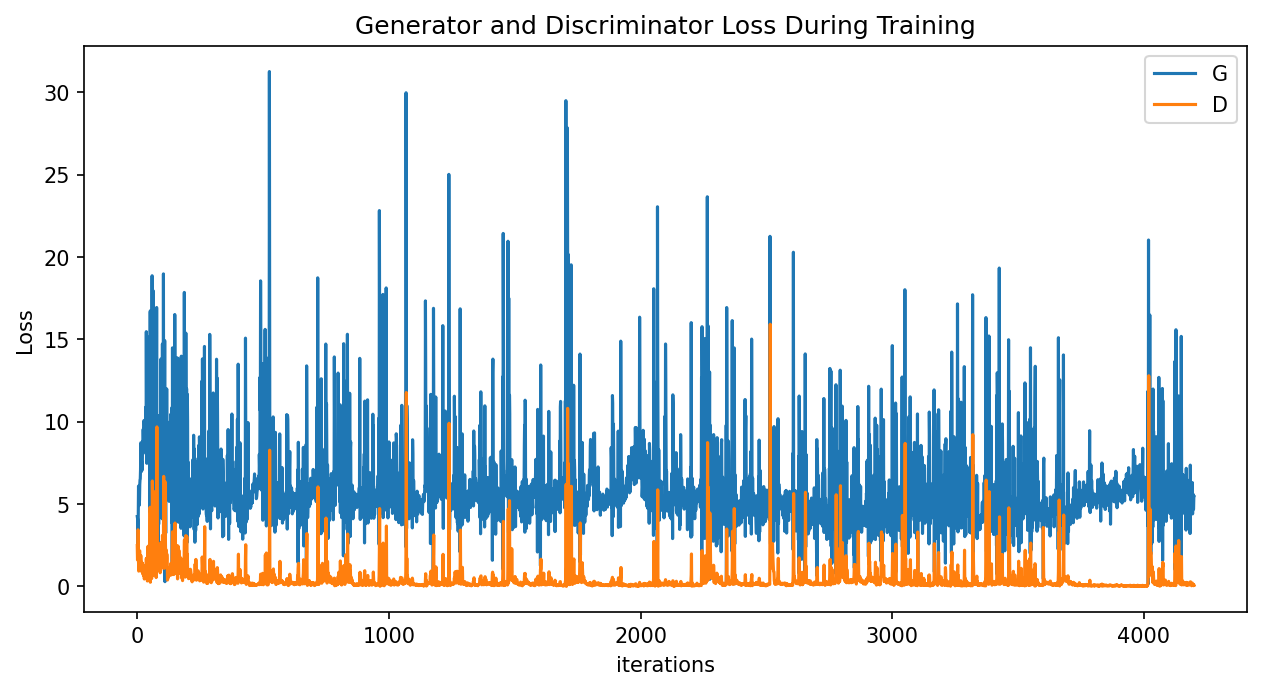

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Save states

In [ ]:
#Runtime on a high ram/gpu instance with a T100, 16gb ram is currently: 

torch.save({'epoch_count': epoch_count,
            'generator_state_dict': generator_model.state_dict(),
            'discriminator_state_dict': discriminator_model.state_dict(),
            'optimizerG_state_dict': G_optimizer.state_dict(),
            'optimizerD_state_dict': D_optimizer.state_dict(),
            'G_loss' : G_losses,
            'D_loss' : D_losses,
            'fixed_noise' : fixed_noise
            }, '/content/drive/MyDrive/datascience/poms/pom-train-4_3_2.pt')